# Munich City

## Import

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr
import shapefile as sh
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import shape, box, LineString, MultiPolygon, Polygon, MultiPoint, Point, LinearRing
from shapely import wkt
from shapely.wkt import loads
from shapely.ops import unary_union
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
# from wktplot import WKTPlot
# from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from IPython.display import Image
# output_notebook()

from platform import python_version
print(f"Py version {python_version()}")
print(f"Shapely version {shapely.__version__}")
print(f"Shapely GEOS version {shapely.geos_version_string}")
print(f"Shapely GEOS C API version {shapely.geos_capi_version_string}")

Py version 3.8.10
Shapely version 2.0.1
Shapely GEOS version 3.11.1
Shapely GEOS C API version 3.11.1-CAPI-1.17.1


In [160]:
pip install rasterio folium numpy contextily geopandas matplotlib

Exception ignored in: <function _after_fork at 0x7f53da8fa700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 1457, in _after_fork
    thread._stop()
TypeError: 'Event' object is not callable


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 4.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Functions

In [44]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def grid2WKT_ring(long_array, lat_array):
    """Create the linearring geometry with requires at least 2 pairs of long, lat coordinates."""
#     coordinates = list(zip(long_array, lat_array))
#     ring_wkt = "LINEARRING(" + ", ".join(f"{x} {y}" for x, y in coordinates) + ")"
    ring_wkt = LinearRing(zip(long_array, lat_array))
    return ring_wkt
  
def geo2grid(lons, lats, xmin, ymax, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(xmin, pixel_size, xskew, ymax, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)

    return xs, ys 

def add_closing_coordinates(d):
    d = str(d)
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

def processRING(ring):
    lat_arr = []
    long_arr = []
    if ring.is_closed == True:
        # Extract longitudes and latitudes
        longitudes, latitudes = zip(ring.xy)
        
        for i in range(len(latitudes[0])):
            long_arr = np.append(long_arr, longitudes[0][i])
            lat_arr = np.append(lat_arr, latitudes[0][i])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridRING_yx = grid2WKT_ring(y_grid, x_grid)

        return gridRING_yx
    else:
        print("Incomplete ring")

        
def processPOLYGON(inputPOLYGON, regionID = None):
    if len(inputPOLYGON.interiors) == 0:
        polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
        coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
        expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
        lat_arr = []
        long_arr = []
        for i in range(len(expected_list_of_coordinates_for_received_code)):
            long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
            lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

        return gridPOLYGON_yx
    else:
        print(f"{regionID}: \x1b[1;31m{len(inputPOLYGON.interiors)}\x1b[0m Polygon Rings Detected")
        mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
        gridPOLYGON_yx = wkt.loads(processPOLYGON(mainPOLYGON))
        
        linear_rings_array = []

        for ring in range(len(inputPOLYGON.interiors)):
            gridRING = processRING(inputPOLYGON.interiors[ring])
            linear_rings_array.append(gridRING)
            
        gridPOLYGON_WITH_HOLE_yx = Polygon(gridPOLYGON_yx.exterior, linear_rings_array)
        print(f"{regionID}: \x1b[1;31m{len(inputPOLYGON.interiors)}\x1b[0m Polygons are Processed")
        
        return gridPOLYGON_WITH_HOLE_yx #return gridPOLYGON_yx_assembled
    
# def processPOLYGON_X(inputPOLYGON, regionID = None):
#     if len(inputPOLYGON.interiors) == 0:
#         polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
#         coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
#         expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
#         lat_arr = []
#         long_arr = []
#         for i in range(len(expected_list_of_coordinates_for_received_code)):
#             long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
#             lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

#         long_list = long_arr.tolist()
#         lat_list = lat_arr.tolist()

#         x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
#         gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

#         return gridPOLYGON_yx
#     else:
#         print(f"{regionID}: Polygon Ring Detected")
#         mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
#         gridPOLYGON_yx = wkt.loads(processPOLYGON_X(mainPOLYGON))
        
#         linear_rings_array = []

#         for ring in range(len(inputPOLYGON.interiors)):
#             gridRING = processRING(inputPOLYGON.interiors[ring])
#             linear_rings_array.append(gridRING)
            
#         gridPOLYGON_WITH_HOLE_yx = Polygon(gridPOLYGON_yx.exterior, linear_rings_array)
        
#         return gridPOLYGON_WITH_HOLE_yx #return gridPOLYGON_yx_assembled
           

######## Mother Function ##############################################################################################
########################################################################################

def geoPOLYGON_to_gridPOLYGON_03(inputREGION, regionID = None):
    polygons_array1 = []
    polygons_array2 = []
    i = 0
    r = 0
    if inputREGION.geom_type == 'Polygon':
        print(f"{regionID}: Polygon is processing")
        return processPOLYGON(inputREGION, regionID)
    
    elif len(list(inputREGION.geoms[0].interiors)) > 0:    # MultiPolygon with atleast 1 inner rings
        print(f"{regionID}: MultiPolygon has Inner Rings")        
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array1.append(gridPOLYGON)
            r = r +1
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array1]
        return shapely.geometry.MultiPolygon(gridMULTI)

    else:                                                  # MultiPolygon with 0 rings
        print(f"{regionID}: MultiPolygon is processing")
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array2.append(gridPOLYGON)
            i = i +1
            #print(f"flag {i}") # i th inner polygon
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array2]
        return shapely.geometry.MultiPolygon(unary_union(gridMULTI))

    
    
    
         

           
          
        
def breakMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        return str("")
    else:
        for polygon in multipolygon.geoms:
            polygons_array.append(polygon)

#     print("# of internal polygons is ",len(polygons_array))
    return polygons_array

def repairMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        print("Flag 1")
        return str("")
    else:
        print("Flag 2")
        for polygon in multipolygon.geoms:
            polygon = wkt.loads(add_closing_coordinates(str(polygon)))
            polygons_array.append(polygon)
    print("Flag 3")
    return unary_union(polygons_array)

def checkMULTIPOLYGONS(df,col_name):
   """checks if a vector data has multipolygons"""
   df = df.assign(isMULTI=df['geometry'].apply(lambda row :len(breakMULTIPOLYGONS(wkt.loads(str(row))))))
   df_multipolygons = df[df['isMULTI'] > 0]
   view = pd.DataFrame({'Districts':df_multipolygons[str(col_name)],'MultiPolygons':df_multipolygons['isMULTI']})
   return view


######## RasDaMan F(X) ##############################################################################################
################################################################################################################

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == (fill_val)] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap(data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis (Longitude)')
    plt.ylabel('y-axis (Latitude)')
    # Displaying the plot
    plt.show()
    return True #return numpy_array   

def query2array(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array
    
def query2numeric(query):
    result = query_executor.execute_read(query) 
    return float("{}".format(result))

def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    return result

def query2tiff(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array
  
def checkRASTER(RASTER_NAME, FILL = 50.0):
    dimension = query2result('select sdom(datacube) from '+str(RASTER_NAME)+' as datacube')
    q_ansi_upper = 'select sdom(t)[0].hi from '+str(RASTER_NAME)+' as t'
    q_lat_upper = 'select sdom(y)[1].hi from '+str(RASTER_NAME)+' as y'
    q_long_upper = 'select sdom(x)[2].hi from '+str(RASTER_NAME)+' as x'
    
    gridTime = int("{}".format(query2result(q_ansi_upper)))+1;  # index start from 0 in rasdaman so +1
    gridLat = int("{}".format(query2result(q_lat_upper)))+1;
    gridLong = int("{}".format(query2result(q_long_upper)))+1;
    
    Time = []
    TOTAL = []
    VALID = []
    RATIO = []
    print("Entering the time loop \n")
    for t in range(0, gridTime):
        q = 'select (raster['+str(t)+', 0:* , 0:*]*0.02)-273.15 from '+str(RASTER_NAME)+' as raster' 
        array = query2array(q)
        if np.count_nonzero(array)*100/array.size >= FILL:   # Threshold parcentage of valid pixels
            Time = np.append(Time, t)
            TOTAL = np.append(TOTAL, array.size)
            VALID = np.append(VALID, np.count_nonzero(array))
            RATIO = np.append(RATIO, np.count_nonzero(array)*100/array.size)
            print(f"Time = {t}, \t VALID = {np.count_nonzero(array)} / {array.size},\t\t Coverage(%) = {'{:.2f}'.format(np.count_nonzero(array)*100/array.size)}")
    
    
    fig = plt.figure(figsize = (16, 5))
    # creating the bar plot
    bar = plt.bar(Time, RATIO, color ='maroon', width = 1)
    # Add counts above the two bar graphs
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

    plt.xlabel("Temporal Snaps")
    plt.ylabel("Valid / Total")
    plt.title(f"Raster Name: {RASTER_NAME}")
    plt.show()

## Vector Data

In [3]:
gdfDist25 = gpd.read_file('/home/arkaghosh/Downloads/MunichCity/VectorData/Munich_25_Bezirke_Dissolved.shp')
gdfSubDist105 = gpd.read_file('/home/arkaghosh/Downloads/MunichCity/VectorData/Munich_105_Bezirke.shp')

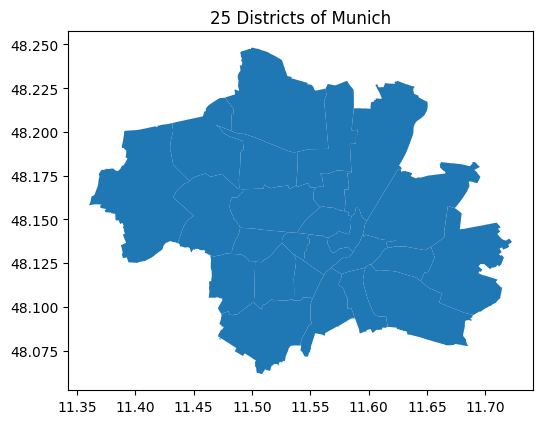

In [4]:
f, ax1 = plt.subplots(figsize=(6, 5))
gdfDist25.plot(ax=ax1)
ax1.set(title="25 Districts of Munich")
plt.show()

In [5]:
gdfDist25.head()

,Nr,FIRST_Bezi,FIRST_Nr,geometry
0,1,Altstadt-Lehel,1,"POLYGON ((11.59520 48.14170, 11.59500 48.14120..."
1,2,Ludwigsvorstadt-Isarvorstadt,2,"POLYGON ((11.55600 48.14080, 11.55930 48.14060..."
2,3,Maxvorstadt,3,"POLYGON ((11.58430 48.14420, 11.58310 48.14140..."
3,4,Schwabing-West,4,"POLYGON ((11.58170 48.17630, 11.58320 48.16940..."
4,5,Au-Haidhausen,5,"POLYGON ((11.59560 48.14050, 11.59590 48.14030..."


Laim


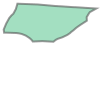

In [6]:
gid = 24 # 0 to 24
print(gdfDist25.FIRST_Bezi[gid])
INPUT = gdfDist25.geometry[gid]
INPUT

In [7]:
INPUT.area

0.0006245799999999138

In [8]:
gridPOLYGON = processPOLYGON(INPUT)
gridPOLYGON

NameError: name 'xmin' is not defined

In [ ]:
gridPOLYGON

In [9]:
gridRING = processRING(INPUT.interiors)
gridRING

AttributeError: 'InteriorRingSequence' object has no attribute 'is_closed'

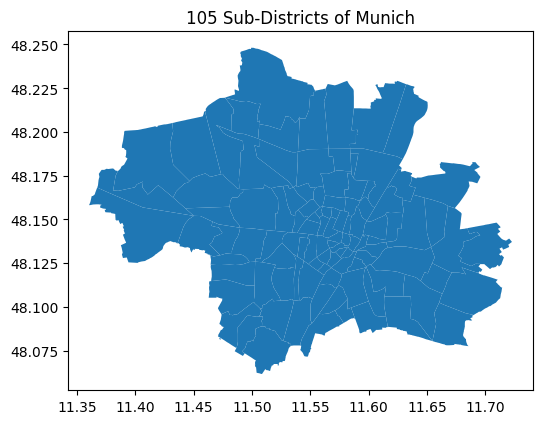

In [10]:
f, ax1 = plt.subplots(figsize=(6, 5))
gdfSubDist105.plot(ax=ax1)
ax1.set(title="105 Sub-Districts of Munich")
plt.show()

In [11]:
gdfSubDist105.head()

,NAME,Bezirk,Nr,geometry
0,Herzogpark,Bogenhausen,13,"POLYGON ((11.59860 48.14920, 11.60530 48.15670..."
1,Daglfing,Bogenhausen,13,"POLYGON ((11.64760 48.16240, 11.65490 48.16110..."
2,Harlaching,Untergiesing-Harlaching,18,"POLYGON ((11.54150 48.07530, 11.54160 48.07560..."
3,Alte Heide - Hirschau,Schwabing-Freimann,12,"POLYGON ((11.58420 48.19040, 11.58450 48.19040..."
4,Steinhausen,Au-Haidhausen,5,"POLYGON ((11.59790 48.13560, 11.59830 48.13710..."


St. Ulrich of Laim


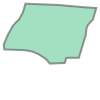

In [12]:
gid = 24
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

Friedenheim of Laim


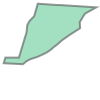

In [13]:
gid = 54 
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

## Raster Data

In [14]:
raster01_path = '/home/arkaghosh/Downloads/MunichCity/RasterData/SRTMGL1_NC.003_30m_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/MunichCity/RasterData/MOD11A1.061_1km_aid0001.nc'

In [15]:
f = xr.open_dataset(raster01_path)
lons = f['lon'].values
lats = f['lat'].values
dem = f['SRTMGL1_DEM'].values

In [16]:
xmax = float(f['lon'].max())
xmin = float(f['lon'].min())
ymin = float(f['lat'].min())
ymax = float(f['lat'].max())

In [17]:
xmin, xmax, ymin, ymax

(11.360833333342422, 11.723055555564933, 48.06166666670512, 48.248055555594156)

In [18]:
pixel_size = 0.0002777777777779992 #0.00833333333258679

## RasDaMan

In [19]:
# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

RasDaMan is running


In [20]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
collection_list = list(collection_list)
collection_list

['LST_03_GeoTIFF_FLIPPED_CRS',
 'South_Tyrol_Temperature_MODIS_1km',
 'LST_03_GeoTIFF_FLIPPED',
 'Bavaria_Temperature_MODIS_1km',
 'Surface_Temperature_Sweden',
 'Munich_Temperature_MODIS_1km',
 'Munich_SRTM_NC_Elevation',
 'Winter_in_sweden1',
 'AIR_TEMP_X',
 'Bavaria_NDVI_250m']

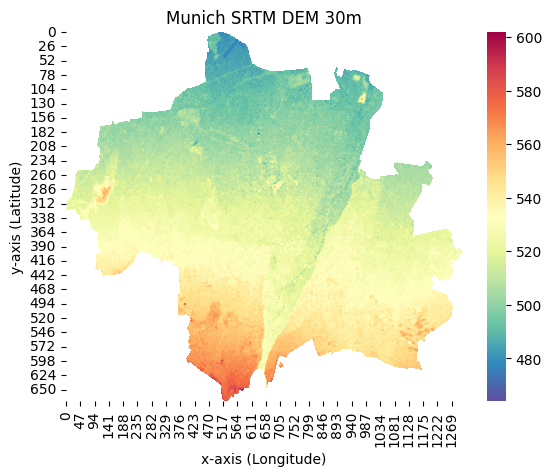

True

In [21]:
q = "select datacube[0, 0:* , 0:*] from Munich_SRTM_NC_Elevation as datacube" #100, 178
query2array2visuallize(q, "Munich SRTM DEM 30m", -32768) # FILL VAL = -32768 (from gdalinfo)

[0:1028,0:22,0:43]
1028
22
43
Entering the time loop 

Time = 0, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 13, 	 VALID = 623 / 1012,		 Coverage(%) = 61.56
Time = 17, 	 VALID = 620 / 1012,		 Coverage(%) = 61.26
Time = 35, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 38, 	 VALID = 621 / 1012,		 Coverage(%) = 61.36
Time = 39, 	 VALID = 624 / 1012,		 Coverage(%) = 61.66
Time = 43, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 49, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 56, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 57, 	 VALID = 625 / 1012,		 Coverage(%) = 61.76
Time = 58, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 61, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 62, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 65, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 67, 	 VALID = 626 / 1012,		 Coverage(%) = 61.86
Time = 68, 	 VALID = 624 / 1012,		 Coverage(%) = 61.66
Time = 77, 	 VALID = 624 / 1012,		 Coverage(%) = 61.66
Time = 79, 

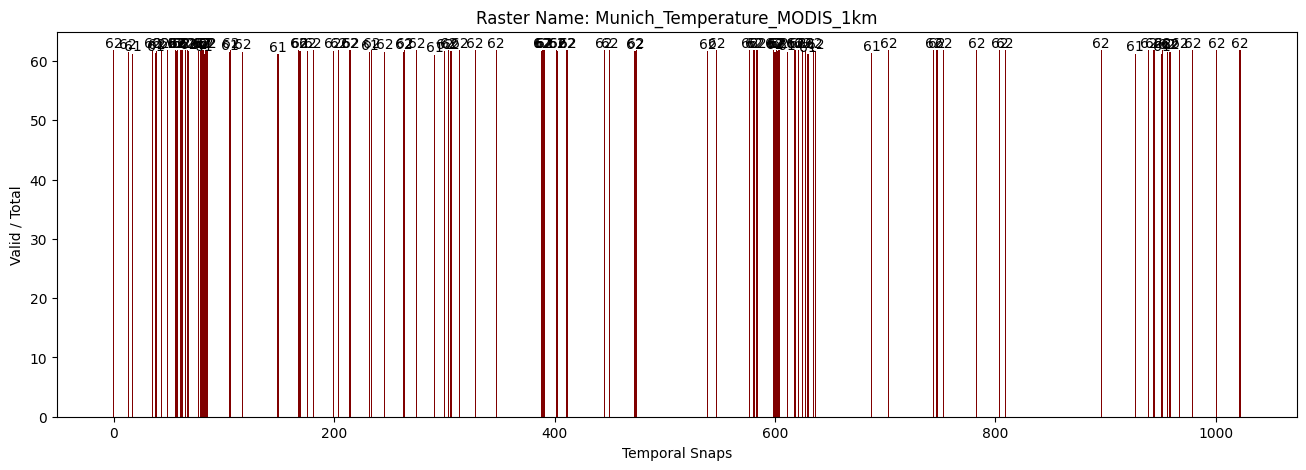

In [22]:
checkRASTER('Munich_Temperature_MODIS_1km', 61) #51% confidense

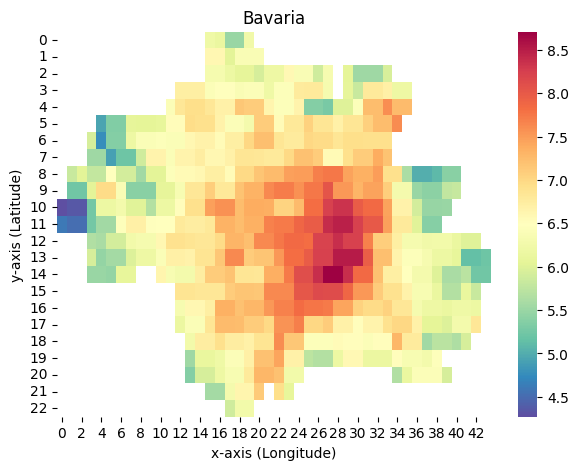

True

In [23]:
q = "select (mr[1022, 0:* , 0:*]*0.02)-273.15 from Munich_Temperature_MODIS_1km as mr" #100, 178
query2array2visuallize(q, "Bavaria", 0)

# Integration

## Laim

Laim


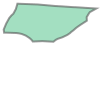

In [24]:
gid = 24 # 0 to 24
print(gdfDist25.FIRST_Bezi[gid])
INPUT = gdfDist25.geometry[gid]
INPUT

In [25]:
qAGGREGATE= 'select avg_cells(clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Munich_SRTM_NC_Elevation as m'
query2numeric(qAGGREGATE)

24: Polygon is processing


531.3272661523625

24: Polygon is processing


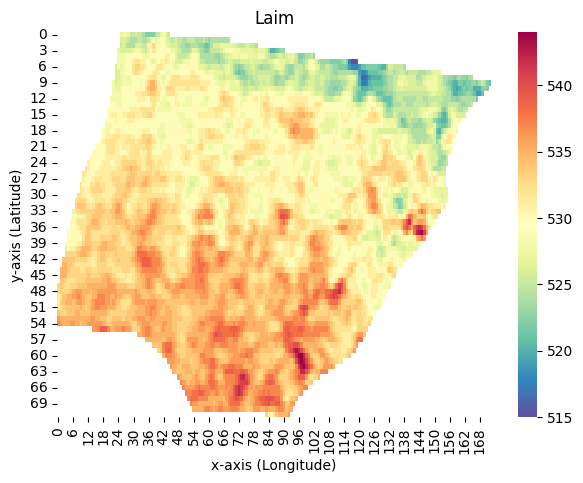

True

In [26]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2array2visuallize(qARRAY, str(gdfDist25.FIRST_Bezi[gid]), -32768)

In [31]:
# qARRAY1= 'select clip(m[1022, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_Temperature_MODIS_1km as m'
# query2array2visuallize(qARRAY1, str(gdfDist25.FIRST_Bezi[gid]), 0)

## St. Ulrich

St. Ulrich of Laim


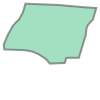

In [32]:
gid = 24
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [33]:
qAGGREGATE= 'select avg_cells(clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Munich_SRTM_NC_Elevation as m'
query2numeric(qAGGREGATE)

24: Polygon is processing


531.9526964844468

24: Polygon is processing


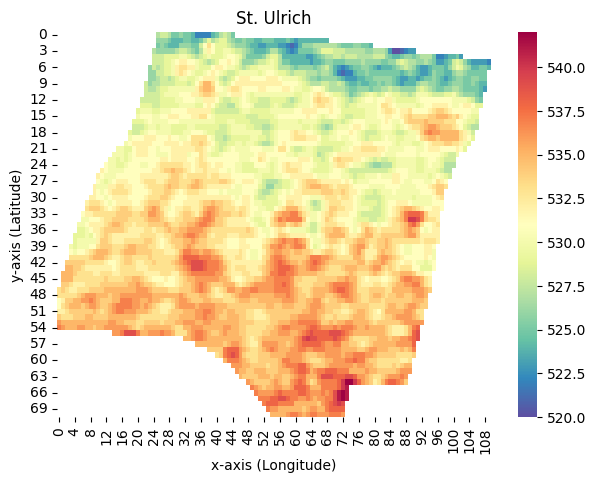

True

In [34]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), -32768)

In [37]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_Temperature_MODIS_1km as m'
query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), 0)

24: Polygon is processing


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "FError: All polygons in the request lie outside the MDDObject's domain. "
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:7002 {created_time:"2024-12-14T23:47:00.104758087+07:00", grpc_status:2, grpc_message:"\x08\x8a\x04\x10\x01\x1a\x46\x45rror: All polygons in the request lie outside the MDDObject\'s domain. \x01"}"
>

## Friedenheim

Friedenheim of Laim


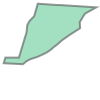

In [79]:
gid = 54
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [229]:
qAGGREGATE= 'select avg_cells(clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Munich_SRTM_NC_Elevation as m'
query2numeric(qAGGREGATE)

54: Polygon is processing


530.2118845500848

54: Polygon is processing


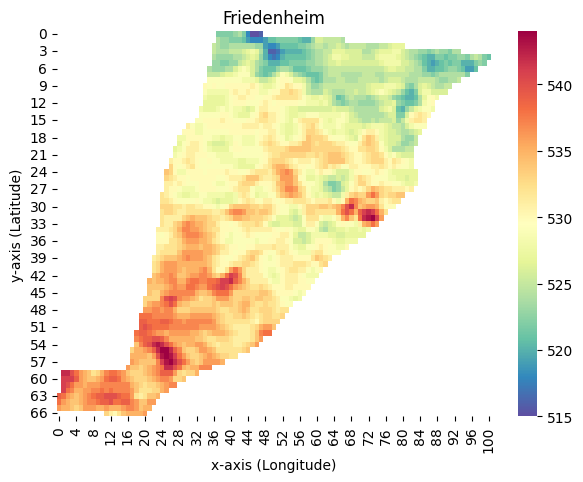

True

In [230]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), -32768)

In [39]:
# qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_Temperature_MODIS_1km as m'
# query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), 0)

## query2geoTIFF ()

- https://geonetcast.wordpress.com/2022/05/12/creating-a-geotiff-from-a-numpy-array/
- https://wiki.openstreetmap.org/wiki/Bounding_box
- http://bboxfinder.com

54: Polygon is processing


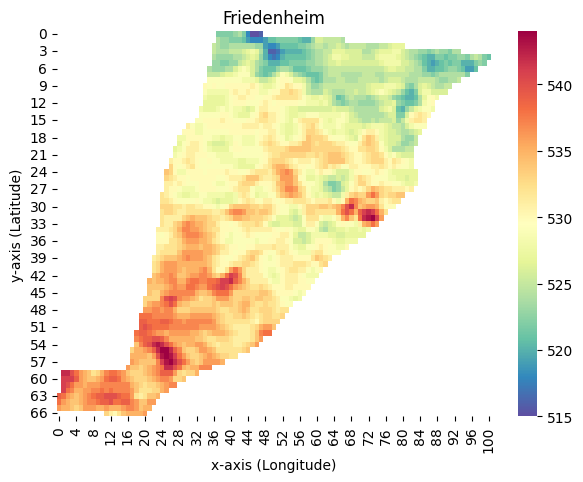

True

In [50]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
query2array2visuallize(qARRAY, str(gdfSubDist105.NAME[gid]), -32768)

In [63]:
OUTPUT = query2tiff(qARRAY, -32768)
OUTPUT

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan, 522., 522., 522., 522., 523., 524., 522.,
        518., 515., 515., 516.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan, 524., 523., 523., 522., 522., 522., 521.,
        519., 518

In [52]:
list(query2tiff(qARRAY, -32768))

[array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan, 522., 522., 522., 522., 523., 524., 522.,
        518., 515., 515., 516.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan]),
 array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan, 524., 523., 523., 522., 522., 522., 521.,
        519., 51

In [58]:
# Create a test 2D array (randon numbers between 0 and 9)
import numpy as np
nlines = 30
ncolumns = 30
data = np.random.randint(0, 100, size=(nlines,ncolumns))

In [65]:
data

array([[35, 25,  2, 19, 12, 22, 87, 42, 36, 51, 50, 80, 60, 31, 35, 73,
        59, 80, 37, 15, 17, 27, 99, 84, 12, 26, 41, 19, 39, 78],
       [94, 76, 94, 77, 72, 40, 38, 14, 73,  9, 28, 22, 49, 60, 70, 92,
        88, 97,  9, 60, 69, 87, 27, 85, 47,  4, 83, 59,  6, 75],
       [78, 68, 96, 95, 27, 70, 28, 84, 31,  3, 10, 89, 40,  0, 86, 80,
        70, 56, 80, 12, 87,  6,  1, 87, 49, 29,  8, 94, 46, 75],
       [19, 30, 26, 93, 96, 57, 84, 19, 77, 71, 49, 45, 47, 13, 70, 15,
        20, 68, 87, 48, 31, 61, 44, 48,  1, 37, 69,  2, 11, 13],
       [66, 80, 70, 71, 56,  0, 31,  8, 45, 99, 59, 30, 32, 94, 98, 61,
        76, 59, 86, 17,  1, 40, 80, 39, 38, 53, 77, 42, 42, 59],
       [25, 76, 45, 56, 68, 97,  4, 78, 17, 74, 49, 43, 98, 33,  4, 57,
        39, 32, 30, 11, 45, 93, 81,  6, 13, 86, 99, 92,  8, 20],
       [69, 56, 88, 17,  1, 12, 22, 89,  3, 85, 69, 42, 76, 78, 21, 41,
        94, 41,  4, 70, 58, 25, 30, 28, 93, 50, 28, 83, 70, 56],
       [ 4, 85, 24,  8, 97, 10, 85, 31, 1

In [60]:
#---------------------------------------------------------------------------------------------------------------------------
# Required modules
from osgeo import gdal, osr, ogr # Python bindings for GDAL
#---------------------------------------------------------------------------------------------------------------------------
 
def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
 
# Define the data extent (min. lon, min. lat, max. lon, max. lat)
extent = [-93.0, -60.00, -25.00, 18.00] # South America
 
# Export the test array to GeoTIFF ================================================
 
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff')
 
# Get dimensions
nlines = data.shape[0]
ncols = data.shape[1]
nbands = len(data.shape)
data_type = gdal.GDT_Int16 # gdal.GDT_Float32
 
# Create a temp grid
#options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
grid_data = driver.Create('grid_data', ncols, nlines, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)
 
# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(data)
 
# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
 
# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nlines, ncols))
 
# Save the file
file_name = 'my_test_data02.tif'
print(f'Generated GeoTIFF: {file_name}')
driver.CreateCopy(file_name, grid_data, 0)  
 
# Close the file
driver = None
grid_data = None
 
# Delete the temp grid
import os                
os.remove('grid_data')


Generated GeoTIFF: my_test_data02.tif


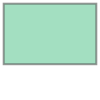

In [87]:
shapely.envelope(INPUT)

In [91]:
print(shapely.envelope(INPUT))

POLYGON ((11.5028 48.1255, 11.5308 48.1255, 11.5308 48.1438, 11.5028 48.1438, 11.5028 48.1255))


In [89]:
shapely.bounds(INPUT).tolist()

[11.5028, 48.1255, 11.5308, 48.1438]

In [95]:
extent = [11.5028, 48.1255, 11.5308, 48.1438] # South America
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff')
# Get dimensions
nrows = OUTPUT.shape[0]
ncols = OUTPUT.shape[1]
nbands = len(OUTPUT.shape)
data_type = gdal.GDT_Float32

In [96]:
nrows, ncols, nbands, data_type

(67, 101, 2, 6)

In [97]:
# Create a temp grid
#options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
grid_data = driver.Create('grid_data', ncols, nrows, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)
 
# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(OUTPUT)
 
# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
 
# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nrows, ncols))
 
# Save the file
file_name = 'Friedenheim02.tif'
print(f'Generated GeoTIFF: {file_name}')
driver.CreateCopy(file_name, grid_data, 0)  
 
# Close the file
driver = None
grid_data = None
 
# Delete the temp grid
import os                
os.remove('grid_data')


Generated GeoTIFF: Friedenheim02.tif


## Biederstein

Biederstein of Schwabing-Freimann


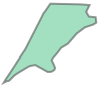

In [112]:
gid = 56
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [113]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'
# query2array(qARRAY, -32768)

56: Polygon is processing


In [132]:
import os    
from shapely import bounds

def query2tiff(query, INPUT, filename = None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
    
    driver = gdal.GetDriverByName('GTiff')  # Get GDAL driver GeoTiff
    extent = shapely.bounds(INPUT).tolist()
    # Get dimensions
    nrows = numpy_array.shape[0]
    ncols = numpy_array.shape[1]
    nbands = len(numpy_array.shape)
    data_type = gdal.GDT_Float32
    # Create a temp grid
    #options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
    grid_data = driver.Create('grid_data', ncols, nrows, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)

    # Write data for each bands
    grid_data.GetRasterBand(1).WriteArray(numpy_array)

    # Lat/Lon WSG84 Spatial Reference System
    srs = osr.SpatialReference()
    srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

    # Setup projection and geo-transform
    grid_data.SetProjection(srs.ExportToWkt())
    grid_data.SetGeoTransform(getGeoTransform(extent, nrows, ncols))

    # Save the file
    file_name = str(filename)+'.tif'
    print(f'Generated GeoTIFF: {file_name}')
    driver.CreateCopy(file_name, grid_data, 0)  

    # Close the file
    driver = None
    grid_data = None

    # Delete the temp grid            
    os.remove('grid_data')

In [117]:
query2tiff(qARRAY, INPUT, -32768)

Generated GeoTIFF: Friedenheim03.tif


## Thalkirchen

Industriebezirk of Allach-Untermenzing


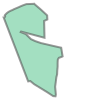

In [230]:
gid = 10
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [134]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'

10: Polygon is processing


In [135]:
query2tiff(qARRAY, INPUT, 'Industriebezirk', -32768)

Generated GeoTIFF: Industriebezirk.tif


# OpenStreetMap

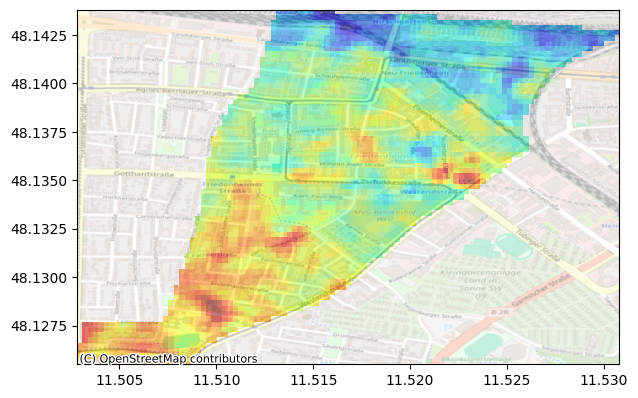

In [226]:
import rasterio
# from rasterio.plot import show  # Ensure show is imported
import matplotlib.pyplot as plt
import contextily as ctx

# Load GeoTIFF
tiff_file = 'Friedenheim02.tif'
with rasterio.open(tiff_file) as src:
    data = src.read(1)
    bounds = src.bounds

# Plot GeoTIFF
fig, ax = plt.subplots()
rasterio.plot.show(data, transform=src.transform, ax=ax, cmap='jet')

# Add OSM tiles
ctx.add_basemap(ax=ax, crs=src.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
# cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

plt.show()


In [260]:
import os    
from shapely import bounds

def query2osm(query, INPUT, filename = None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
    
    driver = gdal.GetDriverByName('GTiff')  # Get GDAL driver GeoTiff
    extent = shapely.bounds(INPUT).tolist()
    # Get dimensions
    nrows = numpy_array.shape[0]
    ncols = numpy_array.shape[1]
    nbands = len(numpy_array.shape)
    data_type = gdal.GDT_Float32
    # Create a temp grid
    #options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
    grid_data = driver.Create('grid_data', ncols, nrows, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)

    # Write data for each bands
    grid_data.GetRasterBand(1).WriteArray(numpy_array)

    # Lat/Lon WSG84 Spatial Reference System
    srs = osr.SpatialReference()
    srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

    # Setup projection and geo-transform
    grid_data.SetProjection(srs.ExportToWkt())
    grid_data.SetGeoTransform(getGeoTransform(extent, nrows, ncols))

    # Save the file
    file_name = str(filename)+'.tif'
    print(f'Generated GeoTIFF: {file_name}')
    driver.CreateCopy(file_name, grid_data, 0)  

    # Close the file
    driver = None
    grid_data = None

    # Delete the temp grid            
    os.remove('grid_data')
    
#     tiff_file = str(filename)+'.tif'
    with rasterio.open(file_name) as src:
        data = src.read(1)
        bounds = src.bounds

    # Plot GeoTIFF
    fig, ax = plt.subplots()
    rasterio.plot.show(data, transform=src.transform, ax=ax, cmap='jet')

    # Add OSM tiles
    ctx.add_basemap(ax=ax, crs=src.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
    # cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

    plt.show()


Trudering - Riem of Tudering-Riem


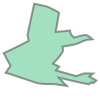

In [261]:
gid = 79
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]
INPUT

In [262]:
qARRAY= 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'

79: Polygon is processing


Generated GeoTIFF: Untermenzing-Allach.tif


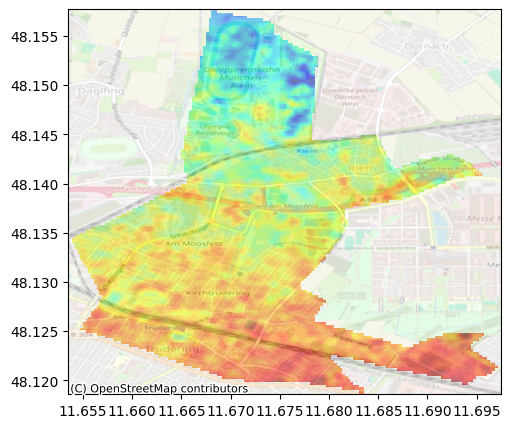

In [263]:
query2osm(qARRAY, INPUT, 'Untermenzing-Allach', -32768)

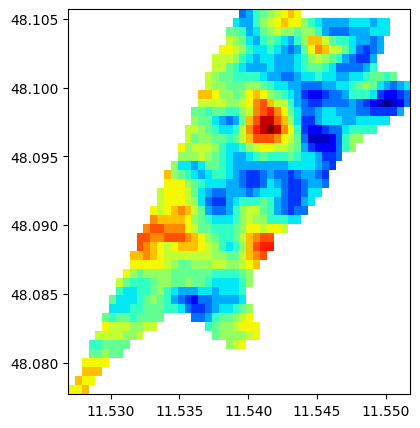

In [200]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import contextily as ctx

# Load GeoTIFF
tiff_file = 'Friedenheim03.tif'
with rasterio.open(tiff_file) as src:
    data = src.read(1)
    bounds = src.bounds  # Get bounds of the GeoTIFF

# Plot GeoTIFF
fig, ax = plt.subplots()
show(data, transform=src.transform, ax=ax, cmap='jet')  # Plot the GeoTIFF

# Set bounds to ensure proper alignment
ax.set_xlim(bounds.left, bounds.right)
ax.set_ylim(bounds.bottom, bounds.top)

# Add OSM basemap
# ctx.add_basemap(ax=ax, crs=src.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()


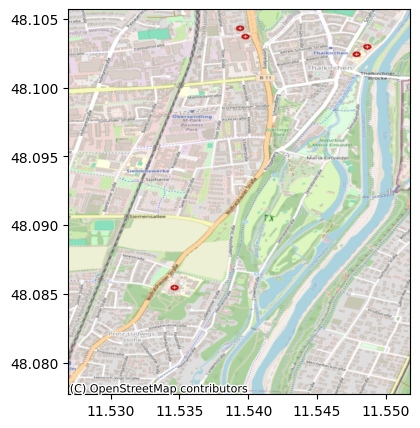

In [196]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import contextily as ctx

# Load GeoTIFF
tiff_file = 'Friedenheim03.tif'
with rasterio.open(tiff_file) as src:
    data = src.read(1)
    crs = src.crs  # Get CRS from GeoTIFF
    transform = src.transform  # Get transform

# Plot GeoTIFF
fig, ax = plt.subplots()
show(data, transform=transform, ax=ax, cmap='jet')  # Display GeoTIFF with jet colormap

# Add OSM tiles using the GeoTIFF's CRS
ctx.add_basemap(ax, crs=crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()


In [167]:
import rasterio
from rasterio.plot import show
import folium
from folium.raster_layers import ImageOverlay
import numpy as np

# Load GeoTIFF
tiff_file = 'Friedenheim03.tif'
with rasterio.open(tiff_file) as src:
    bounds = src.bounds  # Get bounding box
    data = src.read(1)  # Read the first band
    data[data < 0] = 0  # Handle negative values for display purposes
    transform = src.transform

# Calculate image bounds for folium
west, south, east, north = bounds

# Normalize data for visualization
norm_data = (data - np.min(data)) / (np.max(data) - np.min(data))

# Create a Folium map
m = folium.Map(location=[(north + south) / 2, (east + west) / 2], zoom_start=10)

# Add GeoTIFF as an overlay
ImageOverlay(
    image=norm_data,
    bounds=[[south, west], [north, east]],
    colormap='inferno',  # Grayscale
    opacity=0.7,
).add_to(m)

# Add OSM base map
folium.TileLayer('OpenStreetMap').add_to(m)

# Save and display the map
m.save('Friedenheim04.html')


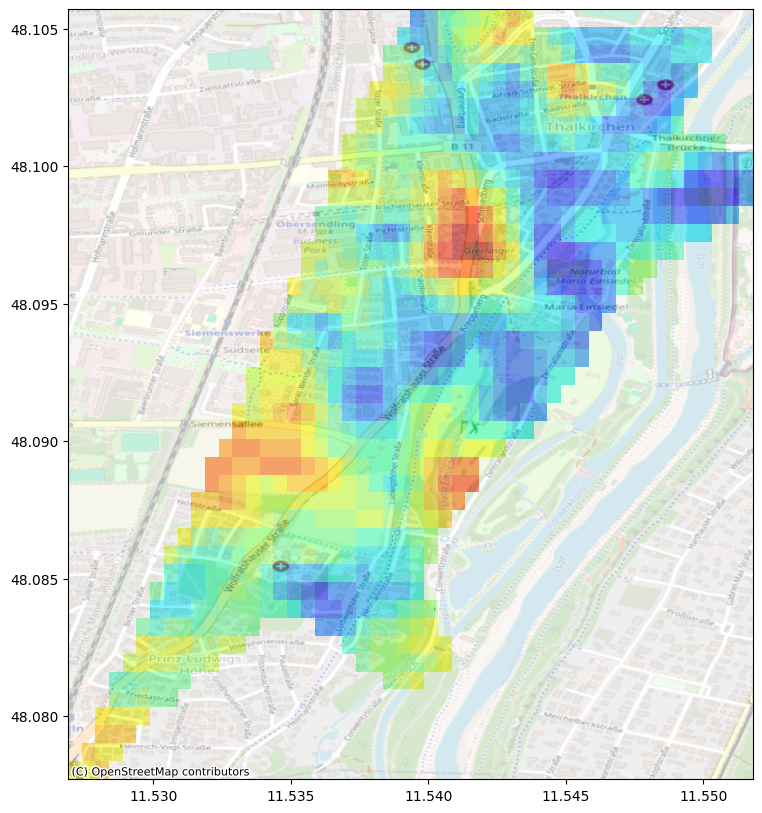

In [264]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import contextily as ctx

# Load GeoTIFF
tiff_file = 'Friedenheim03.tif'
with rasterio.open(tiff_file) as src:
    data = src.read(1)

# Plot GeoTIFF
fig, ax = plt.subplots(figsize=(10, 10))
show(data, transform=src.transform, ax=ax, cmap='jet')  # Plot the GeoTIFF

# Add OSM basemap with transparency
ctx.add_basemap(ax, crs=src.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.show()


# query2covjson ()